## MOM6 data
## MITgcm model
## local norm

In [1]:
import sys 
sys.path.append('../modules/')

In [2]:
%reload_ext autoreload
%autoreload 2
import evaluation

2024-03-08 19:32:24.899345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 19:32:24.899381: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 19:32:24.899387: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
model_nc  = '/home/jovyan/mesoscale_buoyancy_param_ML/ML_model_ncs/MITgcm_all_window_1_local_norm_true_out_para_perp.nc.nc'
data_kind = 'MOM6_P2L' 
exp_name  = 'P2L' 
ML_name   = 'all'

In [4]:
MOM6_bucket = 'gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/'

In [5]:
eval_dic = {}
Lkeys = ['50', '100', '200', '400']
for L in Lkeys: 
    eval_dic[L] = evaluation.full_reader(model_nc, MOM6_bucket, 
                                          L, data_kind, 
                                          exp_name,
                                          ML_name='all',
                                          Tdim='Time',
                                          local_norm=True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_50km.zarr
Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_100km.zarr
Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr
Local normed
Dataset loaded from gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_400km.zarr


In [6]:
import matplotlib.pyplot as plt
import numpy as np

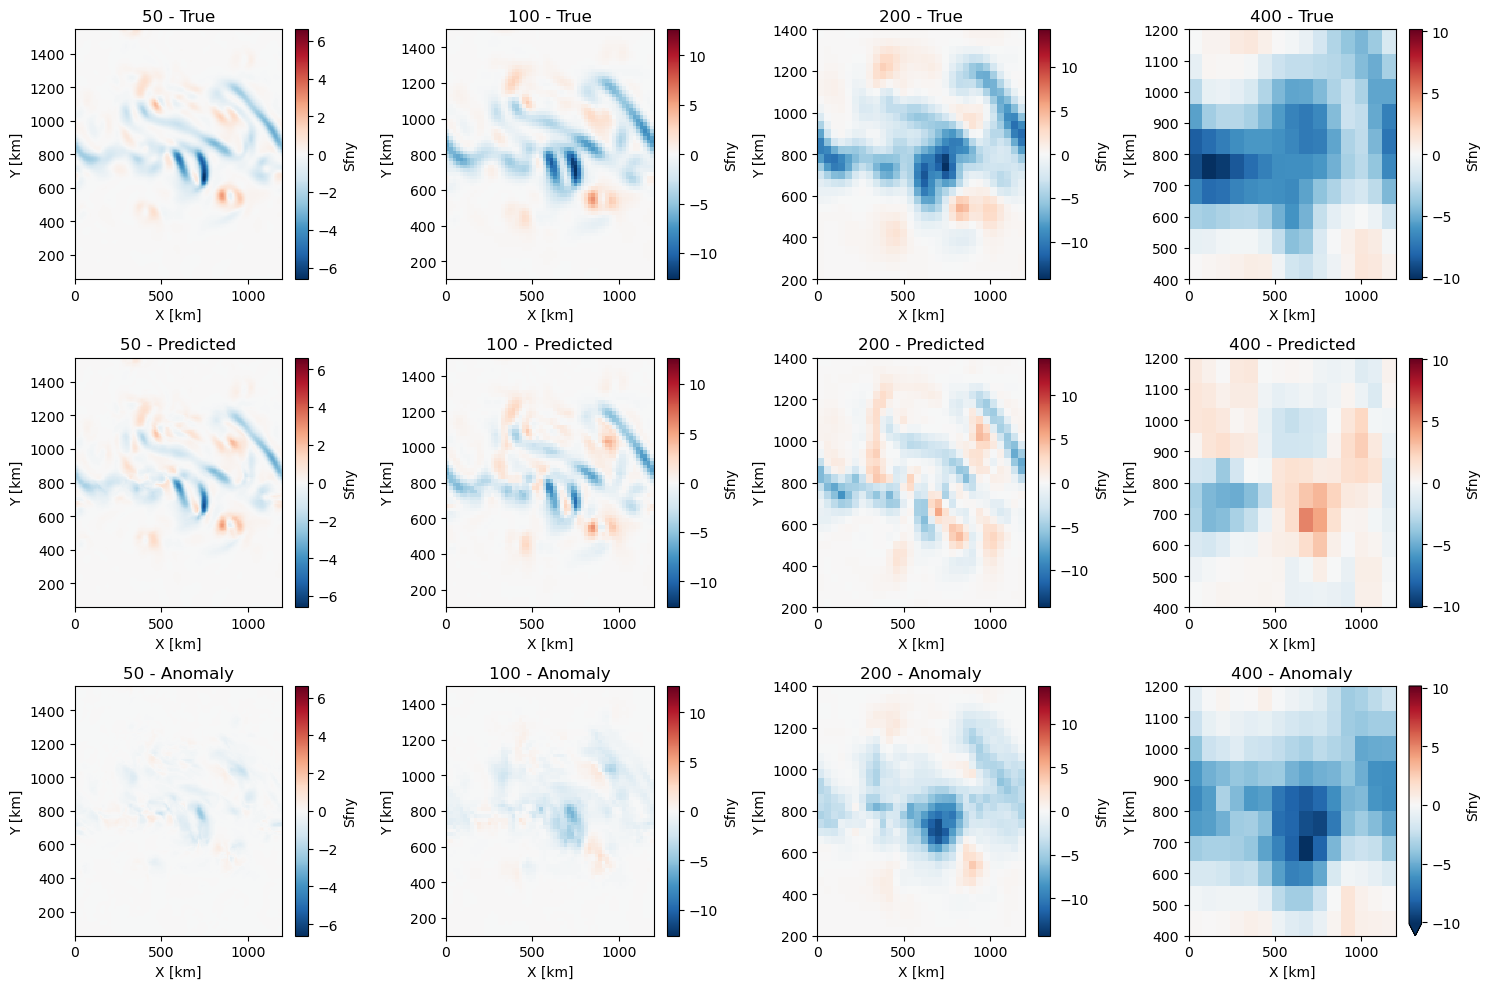

In [7]:
# Create a figure and axis objects
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

# Iterate through the keys '50km', '100km', '200km', and '400km' and plot each dataset
for i, key in enumerate(['50', '100', '200', '400']):
    values = eval_dic[key]
    ds_true = values.output_ds.Sfny.isel(Time=-1)
    ds_pred = values.output_pred_ds.Sfny.isel(Time=-1)
    ds_anomaly = ds_true - ds_pred

    # Plotting true values
    ds_true.plot(ax=axs[0,i], vmin=ds_true.min().values)
    axs[0,i].set_title(f'{key} - True')
    
    # Plotting predicted values
    ds_pred.plot(ax=axs[1,i], vmin=ds_true.min().values)
    axs[1,i].set_title(f'{key} - Predicted')
    
    # Plotting anomaly values
    ds_anomaly.plot(ax=axs[2,i], vmin=ds_true.min().values)
    axs[2,i].set_title(f'{key} - Anomaly')
    
    # Set title and labels
    for j in range(3):
        axs[j,i].set_xlabel('X [km]')
        axs[j,i].set_ylabel('Y [km]')

    
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
#plt.show()

#plt.savefig('./figures/data_MOM6p2l_ML_MITgcm_all_panels.png')

## Metrics:

### Pointwise

In [8]:
Lkeys = ['50', '100', '200', '400']
print('R2:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_R2(dims=['Time','xh','yh']).values) )

R2:
50: 0.9115558083838922
100: 0.8541960859191209
200: 0.6606731736830557
400: 0.50244137801305


In [9]:
Lkeys = ['50', '100', '200', '400']
print('Corr:')
for L in Lkeys: 
    print(L + ': ' + str(eval_dic[L].calc_corr(dims=['Time','xh','yh']).values) )

Corr:
50: 0.9553787287766395
100: 0.9261727733280917
200: 0.8189608117338316
400: 0.7316367665320492


### Spectral 

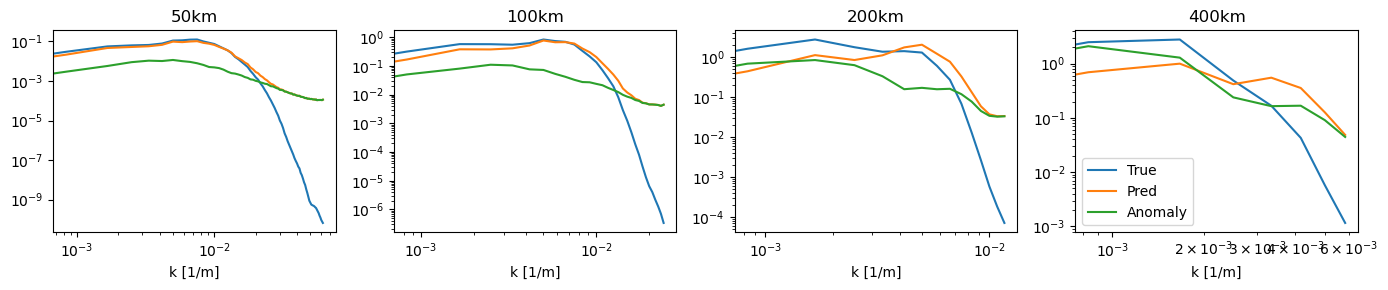

In [10]:
plt.figure(figsize=(14, 3)) 

for i,L in enumerate(Lkeys): 
    true_ps, pred_ps, anom_ps = eval_dic[L].zonal_PS_P2L(var='Sfny', 
                                                     avg_dims=['Time','yh'])
    plt.subplot(1,4,i+1)
    (true_ps * true_ps.freq_xh).plot(label='True')
    (pred_ps * pred_ps.freq_xh).plot(label='Pred')
    (anom_ps * anom_ps.freq_xh).plot(label='Anomaly')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('k [1/m]')
    plt.title(L+'km')

plt.tight_layout()
plt.legend()

#plt.savefig('./figures/data_MOM6p2l_ML_MITgcmall_spectra.png')

### Bulk 

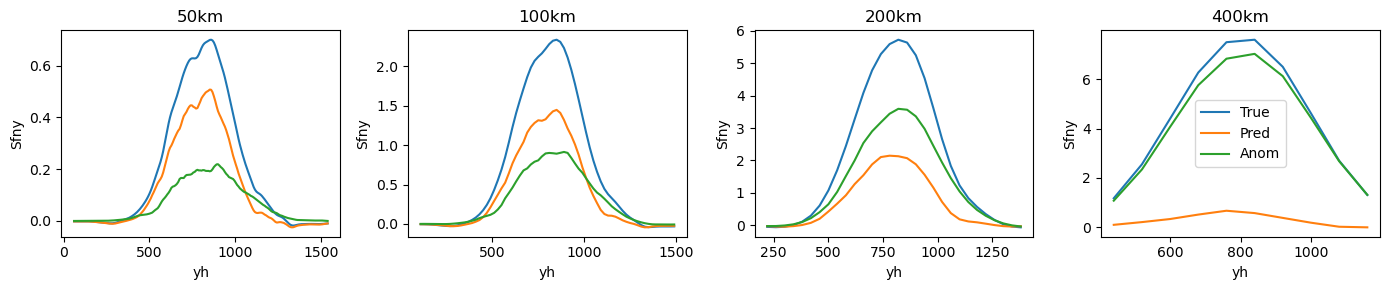

In [11]:
plt.figure(figsize=(14, 3)) 

for i,L in enumerate(Lkeys): 
    true_OT, pred_OT, anom_OT = eval_dic[L].zonal_avg_OT(avg_dims=['Time','xh'])
    
    plt.subplot(1,4,i+1)
    (-true_OT).plot(label='True')
    (-pred_OT).plot(label='Pred')
    (-anom_OT).plot(label='Anom')
    plt.title(L+'km')
    
plt.tight_layout()
plt.legend()

#plt.savefig('./figures/data_MOM6p2l_ML_MITgcmall_OT.png')